In 3D modelling, creating a material is a manual process that involves tweaking a variety of properties. These properties can interact in non-linear ways: for example, changing the material's roughness will only have an effect if the material is relatively reflective.

This goal of this project is to take an image of an object and use a deep learning model to predict what RGB, Metallic, and Roughness values would be required to re-create a similar material in Blender.

* I first generated a synthetic dataset by creating a Python blender script to render 1,000 samples of materials with different property values.
* I then wrote a second script to randomly sample multiple 64x64 patches from each render, creating a dataset of 16,000 images.
* After splitting the dataset into train and valid partitions, I experimented with various architectures, hyperparameter configurations, and losses: CNNs, inception, Adam, rmsprop, MSE/MAE.
* The image below shows various predictions made by my trained model. Red squares show where samples were taken from the source image, while the connected images of spheres preview the material generated using the parameters predicted by the model. The image of the kitchen was cropped from an image by Wikimedia user Oliwerceder (CC BY-SA 4.0).
* The texture of the material was not included in this experiment. However, a great future work idea would be to upgrade the model predict if a texture like wood or grass should be applied.



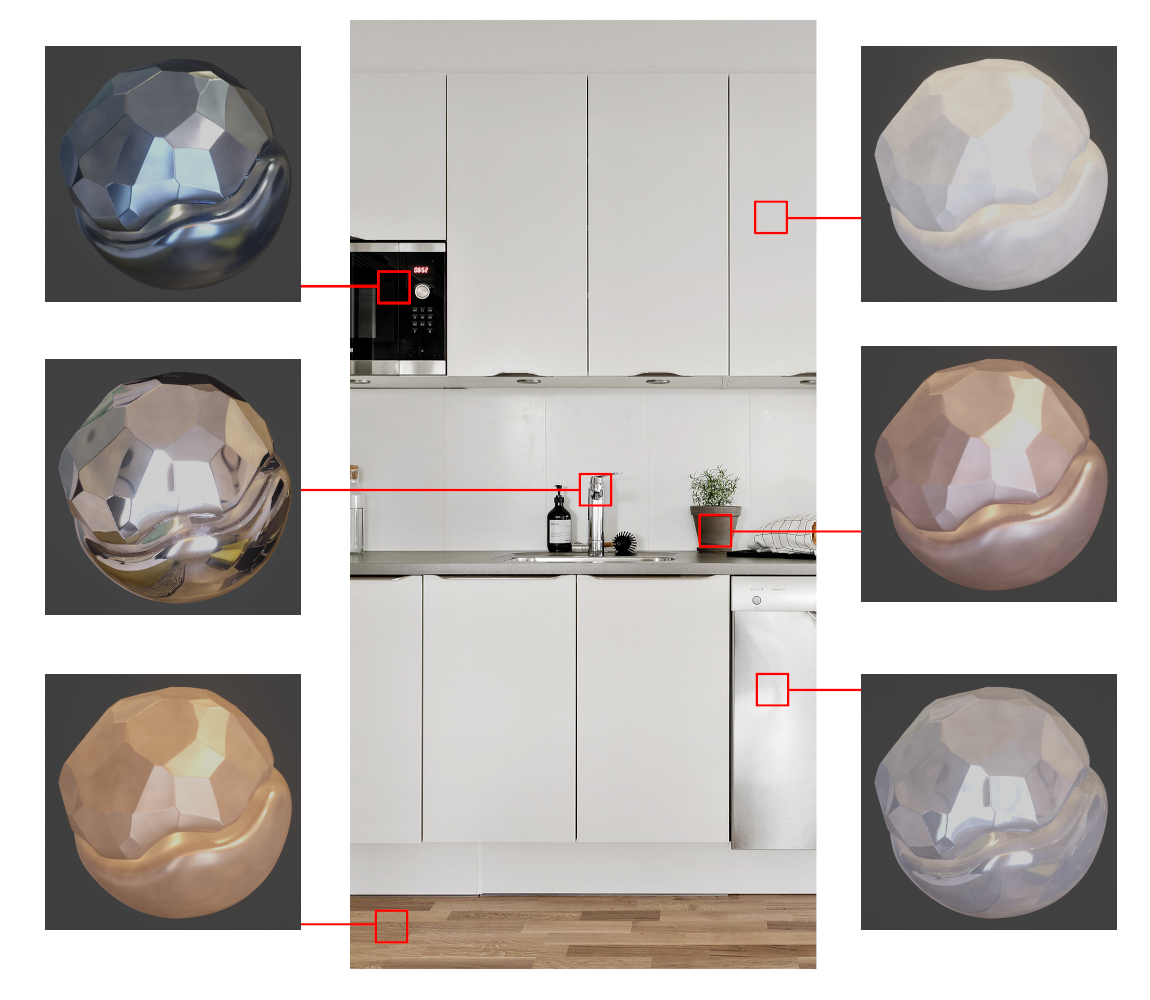

In [ ]:
import google.colab.drive
google.colab.drive.mount("/drive")

Mounted at /drive


In [ ]:
# This is a synthetic dataset I generated using Blender.
!tar -xf "/drive/My Drive/Datasets/blender/dataset-noisy-full.tar.gz"
!ls
!ls -R dataset/parts | grep .png | wc -l

dataset  models  sample_data
16000


In [ ]:
import json
import random
import glob
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL

import tqdm

In [ ]:
IMAGE_SIZE = 64

In [ ]:
def extract(data, props):
    """
    Helper function to yank a specific field out of a nested dict.

    Arguments:
        data dict
            Nested dictionary, ex. {"Principled BSDF": {"Metallic": 0.5}}
        props list
            A list of keys in heirarchical order, ex. ["Principled BSDF", "Metallic"]

    Returns: float
        The relevant value.
    """
    if isinstance(props, str):
        props = [props]

    for prop in props:
        try:
            data = data[prop]
        except KeyError:
            raise KeyError(f'Key "{prop}" not found in data {data}')
        
    return data

def load_manifest(path, keys):
    """
    Helper function to load data from the manifest.

    The manifest should be like:
        { "id": "abc123", "props": {...}}
    
    Where there should exist the corresponding file props/abc123-[0-9].png

    Arguments:
        path str
            The path to the manifest file, which has one JSON formatted entry per line.
        keys str
            List of keys for properties to extract from each entry.
    
    Returns: dict(str, list)
        A dictionary where each key is the source image id and the value is a list of property values.
    """
    labels = {}
    with open(path) as input_stream:
        for line in input_stream:
            entry = json.loads(line)
            props = [extract(entry["props"], key) for key in keys]
            labels[entry["id"]] = props

    return labels

# Train on the properties: RGB, Metallic, and Roughness
KEYS =  [["RGB", "Color", 0], ["RGB", "Color", 1], ["RGB", "Color", 2], ["Principled BSDF", "Metallic"], ["Principled BSDF", "Roughness"]]

# Dictionary of all labels, one per source image
labels = load_manifest("dataset/manifest.txt", KEYS)

# Labels for the dataset, one per sample image. A sample image is a 64x64 patch taken from one of the source images.
ys = []
_, _, paths = next(os.walk("dataset/parts/data/"))
for path in sorted(paths):
    name = os.path.basename(path)
    ident, _ = name.rsplit("-", 1)
    if ident not in labels:
        raise ValueError(
            "Every file in the parts directory must have a matching"
            f" manifest entry, but found an image with unknown identifier '{ident}'"
        )

    ys.append(labels[ident])

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/parts", 
    labels=ys, 
    batch_size=32,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

num_entries = len(ys)
num_valid = int(num_entries * 0.2 / 32)

dataset_valid = dataset.take(num_valid)
dataset_train = dataset.skip(num_valid).take(num_entries)

print("Valid", len(dataset_valid))
print("Train", len(dataset_train))

Found 16000 files belonging to 1 classes.
Valid 100
Train 400


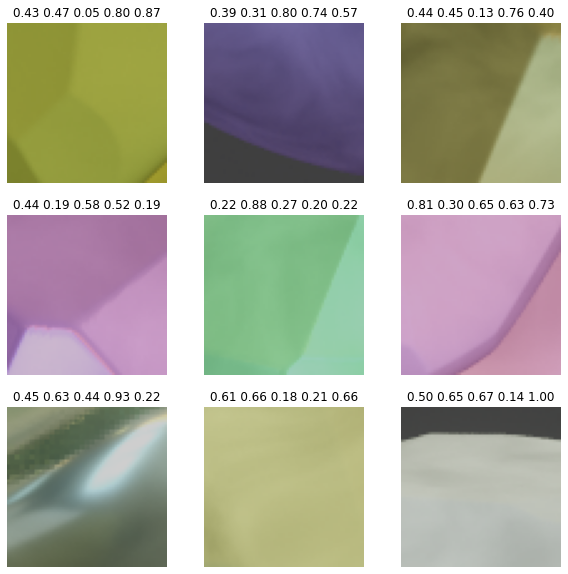

In [ ]:
# Quick preview of the dataset. Properties are in order: red, green blue, metallic, roughness.
images, values = next(dataset_train.as_numpy_iterator())
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    
    plt.imshow(images[i].astype("uint8"))
    title = " ".join([f"{val:.2f}" for val in values[i]])
    plt.title(title)
    plt.axis("off")

In [ ]:
def make_classifier(image_size, output_dims):
    """
    Helper function to create a classifier model.

    Arguments:
        image_size int
            Width or height of the square image, in pixels.
        output_dims int
            Dimensionality of the output.

    Returns:
        keras.Model
    """
    input_images = tf.keras.layers.Input((image_size, image_size, 3), dtype=tf.float32)

    # Normalization
    image_data = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(
        input_images
    )

    # Data augmentation
    # image_data = tf.keras.layers.experimental.preprocessing.RandomFlip(
    #     "horizontal_and_vertical"
    # )(image_data)
    # image_data = tf.keras.layers.experimental.preprocessing.RandomRotation(1.0)(
    #     image_data
    # )
    # image_data = tf.keras.layers.experimental.preprocessing.RandomZoom(0.3, 0.3)(
    #     image_data
    # )

    # I actually experimented with a variety of CNNs with different configurations,
    # but settled on this simple one based on https://www.tensorflow.org/tutorials/images/classification.
    block = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(image_data.shape[1:]),
            tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(output_dims),
        ],
        name="block"
    )
    block.summary()

    logits = block(image_data)

    model = tf.keras.Model(input_images, logits)
    model.compile(
        loss="mean_squared_error", metrics=["mean_absolute_error"], optimizer="adam"
    )
    
    return model

model = make_classifier(IMAGE_SIZE, len(KEYS))
model.summary()

Model: "block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0     

In [ ]:
model.fit(dataset_train, epochs=20, validation_data=dataset_valid)

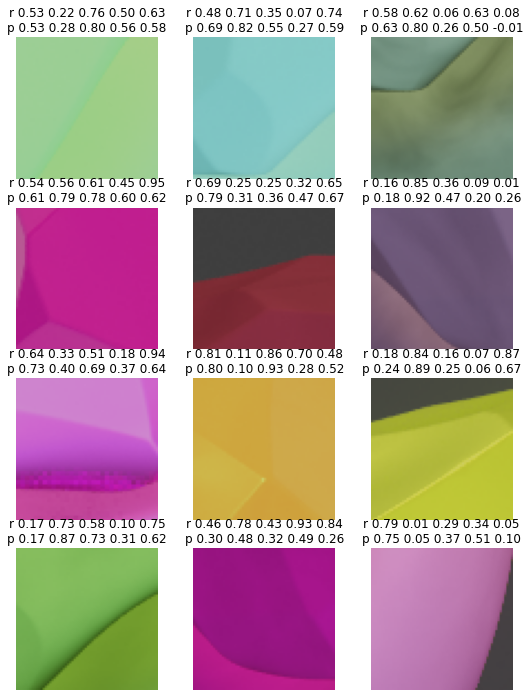

In [ ]:
images, values = next(dataset_train.as_numpy_iterator())
xt = images[:16]
yt = values[:16]
images, values = next(dataset_valid.as_numpy_iterator())
xt[8:] = images[:8]
yt[8:] = values[:8]

preds = model.predict(xt)
plt.figure(figsize=(9,12))
for i in range(12):
    ax = plt.subplot(4, 3, i + 1)

    plt.imshow(images[i].astype("uint8"))

    title = "\n".join([
        " ".join(["r"] + [f"{val:.2f}" for val in yt[i]]),
        " ".join(["p"] + [f"{val:.2f}" for val in preds[i]]),
    ])
    plt.title(title)
    plt.axis("off")

In [ ]:
model.save("/drive/My Drive/Datasets/blender/material_eyedropper")

INFO:tensorflow:Assets written to: /drive/My Drive/Datasets/blender/material_eyedropper/assets
